# Ergodic DGME Reference

Ethan Zell


In this example,

$$f(x,a) = 4\sum_{y\neq x} (a_{xy} - 2)^2,$$

$$F(x,\eta) = \eta_x,$$

and so the ergodic system has value $\bar\rho = \rho = 1/d$, $d \geq 2$.

In [1]:
import tensorflow as tf
import numpy as np
import math, keras, random, copy
tf.random.set_seed(703)
np.random.seed(703)

In [2]:
# define d beforehand, just in case
d=2

In [3]:
class DatasetGenerator:
  '''
  A class that generates the dataset for the DGM.
  '''
  def __init__(self, d=d):
    self.x_data = None
    self.eta_data = None
    self.d = d

  def uniformly_random_measure(self):
    '''
    Uses exponential random variables to generate a uniformly random probability vector.
    '''
    pre_normalized = np.random.exponential(1, size = (self.d,))
    return pre_normalized / sum(pre_normalized)

  def uniformly_random_measure_vec(self, samples):
    '''
    Vectorizes the prior function.
    '''
    data = np.zeros((samples, self.d))
    for k in range(samples):
      data[k,:] = self.uniformly_random_measure()
    return data

  def generate_dataset(self, samples=1000):

    '''
    Creates the dataset which, for the DGME, needs x and eta data.
    '''

    x_data = np.random.choice([float(m) for m in range(self.d)],size=samples)
    eta_data = self.uniformly_random_measure_vec(samples = samples)

    self.x_data = x_data
    self.eta_data = eta_data

    return x_data, eta_data

  def data_to_tensors(self):

    self.x_data = tf.convert_to_tensor(self.x_data, dtype = 'float32')
    self.eta_data = tf.convert_to_tensor(self.eta_data, dtype = 'float32')

    return self.x_data, self.eta_data

In [4]:
class DGMModel(tf.keras.Model):
  '''
  This class defines the neural network model.
  '''
  def __init__(self, architecture):
    super(DGMModel, self).__init__()
    self.architecture = architecture # you can give a list specifying the number of nodes in each dense layer
    self.layer_list = []

    for i,number_of_nodes in enumerate(architecture):
      if i == 0:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
      else:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
    self.layer_list.append(tf.keras.layers.Dense(units=1, activation = 'elu'))

  def call(self, x, eta):
    x = tf.expand_dims(x, axis = -1)
    input = tf.concat([x, eta], 1)
    result = input
    for layer in self.layer_list:
      result = layer(result)
    return result

Recall from the paper that we are interested in approximately solving the master equation:

$$
\rho = H(x,\Delta_x U_0(\cdot,\eta))+ F(x,\eta) + \sum_{y,z\in [d]} D^\eta_{yz} U_0(x,\eta) \gamma^*_z(y,\Delta_y U_0(\cdot,\eta)) \eta_y,
$$

where in this example:

$$F(x,\eta) = \eta_x,$$

$$H(x,p) := \min_{a} \Big\{\frac{1}{2}|a|^2 + a\cdot p\Big\},$$

and where $\gamma^*$ is the associated minimal argument that minimizes the Hamiltonian $H$. Recall that $\Delta_x b:= (b_y - b_x)_{y\in [d]}$ is a finite difference vector and $D^\eta_{yz}$ denotes the directional derivative in the $z$ minus $y$ direction (in terms of the standard basis).

In the Loss class below, $F$ is referred to as the mean_field_cost and $H$ is the Hamiltonian.

In [5]:
class Loss():
  '''
  This class defines the loss and involves the entire PDE.
  '''

  def __init__(self, model, d, a = 2., a_l = 1., a_u = 3., b = 4.):
    self.model = model
    self.d = d
    self.a = a
    self.a_l = a_l
    self.a_u = a_u
    self.b = b
    return

  def a_star(self, psi_left, psi_right):
    '''
    The computed value of $\gamma^*$, the minimal argument of the Hamiltonian. The paper derives this formula explicitly.
    '''
    numerator = psi_left - psi_right
    return ( numerator / ( (self.a_u - self.a_l) * self.b) ) + self.a

  def Hamiltonian_z1(self, x, z1_state_tensor, psi_output, psi_z1_output):
    '''
    The Hamiltonian, denoted H in the paper.
    '''
    a_star_z1 = self.a_star(psi_output, psi_z1_output)
    where_unequal = tf.cast(tf.math.logical_not(tf.math.equal(x, z1_state_tensor)), dtype = 'float32')
    pre_running = a_star_z1 - ( self.a * tf.ones(shape = a_star_z1.shape, dtype='float32') )
    running_cost = self.b * tf.multiply(tf.math.square(pre_running), where_unequal)
    change_of_state = tf.multiply(a_star_z1, (psi_z1_output - psi_output))
    return running_cost + change_of_state

  def interaction_sum_term_z1_z2(self, z1, z2, eta, eta_derivative, psi_z1, psi_z2):
    '''
    This is an individual term from the sum part of the PDE.
    '''
    mf = eta[:,int(z1)]
    directional_derivative = eta_derivative[:,int(z2)] - eta_derivative[:,int(z1)]
    control = self.a_star(psi_z1, psi_z2)
    result = tf.multiply(tf.multiply(mf, directional_derivative), control)
    return result

  def mean_field_cost(self, x, eta):
    '''
    The common cost, denoted F in the paper.
    '''
    mf = np.zeros(x.shape)
    for i,entry in enumerate(x):
      mf[i] = eta[i, int(entry)]
    mfc = tf.convert_to_tensor(mf, dtype='float32')
    return mfc

  def derivatives(self, x, eta):

    '''
    The time and measure derivatives are needed to compute the interaction_sum_term_z1_z2 function. This then goes into the sum term of the PDE.
    '''

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(eta)
        V = self.model(x,eta)
    eta_derivative = tape2.gradient(V,eta)

    self.eta_derivative = eta_derivative

    return eta_derivative

  def criterion(self, x, eta):

    '''
    Combining all the prior terms into the loss. We need two for loops in order to compute the sum term.
    '''

    eta_derivative = self.derivatives(x, eta)
    output = tf.squeeze(self.model(x, eta))

    sum = tf.ones(x.shape) * -0.5 # changed to accomodate for rho
    for z1 in range(d):

      z1_state_tensor = z1 * tf.ones(shape = x.shape, dtype='float32')
      psi_z1 = tf.squeeze(self.model(z1_state_tensor, eta))
      sum += self.Hamiltonian_z1(x, z1_state_tensor, output, psi_z1)

      for z2 in range(d):

        z2_state_tensor = z2 * tf.ones(shape = x.shape, dtype='float32')
        psi_z2 = tf.squeeze(self.model(z2_state_tensor, eta))
        term = self.interaction_sum_term_z1_z2(z1, z2, eta, eta_derivative, psi_z1, psi_z2)
        sum += self.interaction_sum_term_z1_z2(z1, z2, eta, eta_derivative, psi_z1, psi_z2)

    mean_field_cost = self.mean_field_cost(x, eta)

    loss_sum = sum + mean_field_cost

    squared_loss = tf.math.square(loss_sum)

    return squared_loss # not yet reduced

  def total_criterion(self, x, eta):
    unreduced_loss = self.criterion(x, eta)
    loss = tf.reduce_mean(unreduced_loss)
    return loss

In [ ]:
class Train():
  def __init__(self, model, dataset_generator, b=1., return_losses = False, verbose = False, visual_output = False):
    self.model = model
    self.dsg = dataset_generator
    self.return_losses = return_losses
    self.losses = []
    self.verbose = verbose
    self.visual_output = visual_output
    self.b = b

  def loss_gradient(self):
    loss_fn = Loss(model = self.model, d = d, b=self.b)
    with tf.GradientTape(persistent=True) as loss_tape:
      loss = loss_fn.total_criterion(self.x, self.eta)
    return loss, loss_tape.gradient(loss, self.model.trainable_variables)

  def step(self, optimizer):

    '''
    A single step in the training regime of the neural network.
    '''

    loss, loss_grad = self.loss_gradient()

    if self.verbose:
      self.avg_losses.append(loss.numpy())

    if self.return_losses:
      self.losses.append(loss)

    optimizer.apply_gradients(zip(loss_grad, self.model.trainable_variables))
    return self.model

  def train_nn(self, epochs, steps_per_epoch, learning_rate = 1e-3, verbose=False):

    '''
    The main training function to train the neural network.
    '''

    print('Training the DGM network.')

    lr_fn = tf.optimizers.schedules.PolynomialDecay(initial_learning_rate=learning_rate, decay_steps = int(epochs*steps_per_epoch),
                                                    end_learning_rate=1e-6, power = 0.9)
    opt = tf.keras.optimizers.Adam(lr_fn)

    for m in range(epochs):

      self.avg_losses = []

      self.dsg.generate_dataset()
      self.x, self.eta = self.dsg.data_to_tensors()

      for step in range(steps_per_epoch):

        self.model = self.step(opt)

      if self.verbose:
        print(f'Avg loss for epoch {m} was: {np.mean(self.avg_losses)}')


    self.model.save_weights('dgm_weights')

    if self.return_losses:
      return self.model, self.losses
    return self.model

In [ ]:
# implementation
d=3
trainer = Train(model = DGMModel([d+2,50,50,50]), dataset_generator = DatasetGenerator(d=d), verbose=True)
trainer.train_nn(epochs = 200, steps_per_epoch=20, learning_rate = 1e-3)
# save whole model
try:
  trainer.model.save(f'drive/MyDrive/erg_model_tf_3', save_format = 'tf')
except:
  trainer.model.save(f'erg_model_tf_3', save_format = 'tf')

Training the DGM network.


Avg loss for epoch 0 was: 0.09611435234546661
Avg loss for epoch 1 was: 0.06506656110286713
Avg loss for epoch 2 was: 0.04606367647647858
Avg loss for epoch 3 was: 0.03262268379330635
Avg loss for epoch 4 was: 0.0216505229473114
Avg loss for epoch 5 was: 0.016267387196421623
Avg loss for epoch 6 was: 0.015931759029626846
Avg loss for epoch 7 was: 0.013267655856907368
Avg loss for epoch 8 was: 0.012478339485824108
Avg loss for epoch 9 was: 0.011268752627074718
Avg loss for epoch 10 was: 0.01087578572332859
Avg loss for epoch 11 was: 0.010561694391071796
Avg loss for epoch 12 was: 0.009789364412426949
Avg loss for epoch 13 was: 0.010142943821847439
Avg loss for epoch 14 was: 0.008986862376332283
Avg loss for epoch 15 was: 0.008577700704336166
Avg loss for epoch 16 was: 0.008262506686151028
Avg loss for epoch 17 was: 0.008478171192109585
Avg loss for epoch 18 was: 0.00818553939461708
Avg loss for epoch 19 was: 0.0080197062343359
Avg loss for epoch 20 was: 0.007149156183004379
Avg loss for

In [ ]:
trainer.model.save(f'erg_model_tf_3', save_format = 'tf')

In [ ]:

# graphing functions

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import imageio
import copy
import matplotlib as mpl
import plotly.graph_objects as go
import keras
import tensorflow as tf
import numpy as np

In [ ]:
d=3
loaded_model = keras.models.load_model('drive/MyDrive/erg_model_tf_3')
loaded_model.compile()

In [ ]:
class VizErg:
  def __init__(self, model, num_measure_points = 1_000):
    self.model = model
    self.num_points = num_measure_points

  def single_graph_population_updated(self, x=0.):
    '''
    This function gets the values from the neural network, populated on the simplex. Only for d=2.
    '''
    two_simplex = np.linspace(start = 0, stop = 1, num = self.num_points, endpoint = True)
    eta_data = np.zeros((self.num_points, d))
    eta_data[:,0] = two_simplex
    eta_data[:,1] = 1. - two_simplex
    eta_data = tf.convert_to_tensor(eta_data, dtype='float32')
    x = tf.fill((self.num_points,), x)
    y = self.model(x,eta_data)
    y_for_graph = y.numpy()[:,0]
    return two_simplex, y_for_graph

  def display_single_graph_updated(self, x=0.):
    '''
    Uses the prior function to graph the DGME neural network's values. Only for d=2.
    '''
    two_simplex, y_for_graph = self.single_graph_population_updated(x=x)
    fig, ax = plt.subplots(figsize=(6, 4)) #, tight_layout=True)
    ax.set_ylim([0,1])
    ax.plot(two_simplex, y_for_graph)
    ax.set_xlabel(f'$\mu(x=1)$')
    ax.set_ylabel(f'$U(x={int(x)+1},\eta=\mu)$')
    ax.set_title(r'')
    ax.plot(two_simplex, y_for_graph, color = 'black')
    return

  def gamma_difference(self, num):
    return (num / ((3. - 1.) * 4.) )

  def display_control_difference(self, orientation = 0):
    # orientation is states 2-1 aka 1-0
    two_simplex, y0_for_graph = self.single_graph_population_updated(x=0.)
    two_simplex, y1_for_graph = self.single_graph_population_updated(x=1.)
    if orientation == 0:
      y_for_graph = self.gamma_difference(y1_for_graph - y0_for_graph)
    else:
       y_for_graph = self.gamma_difference(y0_for_graph - y1_for_graph)
    fig, ax = plt.subplots(figsize=(6, 4)) #, tight_layout=True)
    ax.plot(two_simplex, y_for_graph)
    ax.set_ylim([-0.04,0.04])
    ax.set_xlabel(f'$\eta_1$')
    ax.set_ylabel(f'')
    if orientation == 1:
      ax.set_title(r'Difference of rates: $\gamma^*_2(1,\Delta_1 U_0(\cdot, \eta)) - \gamma^*_2(1,\Delta_1 \bar u)$')
    else:
      ax.set_title(r'Difference of rates: $\gamma^*_1(2,\Delta_2 U_0(\cdot, \eta)) - \gamma^*_1(2,\Delta_2 \bar u)$')
    ax.plot(two_simplex, y_for_graph, color = 'black')
    return

  def display_heatmap(self, num_points = 25, orientation = [0,1]):
    '''
    A specific function to graph the DGME network's values in the case d=3.
    '''
    # create numpy array of inputs
    num_array = int(num_points*(num_points+3)/2.) + 1
    eta_data = np.zeros((num_array, 3))
    k=0
    num_round = 0
    for i in range(num_points + 1):
      for j in range(num_points - i + 1):
        eta1 = float(i)/num_points
        eta2 = float(j)/num_points
        eta3 = 1. - eta1 - eta2
        eta_data[k, 0] = eta1
        eta_data[k, 1] = eta2
        eta_data[k, 2] = eta3
        k+=1
    eta_data = tf.convert_to_tensor(eta_data, dtype='float32')
    x0_data = tf.fill((num_array,), 0.)
    y0_output = self.model(x0_data, eta_data)
    x1_data = tf.fill((num_array,), 1.)
    y1_output = self.model(x1_data, eta_data)
    x2_data = tf.fill((num_array,), 2.)
    y2_output = self.model(x2_data, eta_data)

    outputs = [y0_output, y1_output, y2_output]

    grid_data = np.zeros((num_points+1, num_points+1))
    np_out = self.gamma_difference(outputs[orientation[0]].numpy()[:,0] - outputs[orientation[1]].numpy()[:,0]) #changed
    i = num_points
    j = 0
    for k in range(num_array):
      grid_data[i,j] = np_out[k]
      if j == i:
        i -= 1
        j = 0
      else:
        j += 1

    skip = 3
    x_labels = []
    for i in range(grid_data.shape[0]):
      if i % skip == 0:
        val = round(i/(grid_data.shape[0]-1),2)
      else:
        val = ''
      x_labels.append(val)
    y_labels = []
    for i in range(grid_data.shape[1]):
      if i % skip == 0:
        val = round(1.- i/(grid_data.shape[1]-1),2)
      else:
        val = ''
      y_labels.append(val)

    mask = np.triu(np.ones_like(grid_data, dtype=bool))

    # x_labels = [round(i/(grid_data.shape[0]-1),2) for i in range(0,grid_data.shape[0],2)]
    # y_labels = [round(1.- i/(grid_data.shape[1]-1),2) for i in range(0, grid_data.shape[1],2)]
    ax = sns.heatmap(grid_data, mask=mask, xticklabels=x_labels, vmin = -0.01, vmax=0.01, yticklabels=y_labels, cmap="PiYG")

    # decrease density of tick labels
    for index, label in enumerate(ax.get_xticklabels()):
      if index % 2 == 0:
          label.set_visible(True)
      else:
          label.set_visible(False)

    for index, label in enumerate(ax.get_yticklabels()):
      if index % 2 == 0:
          label.set_visible(True)
      else:
          label.set_visible(False)

    ax.set_xlabel(f'$\eta_2$')
    ax.set_ylabel('$\eta_1$')

    ax.set_title(f'Difference of rates, transitioning from state {orientation[0]+1} to state {orientation[1]+1}')

    plt.show()

    return ax, outputs


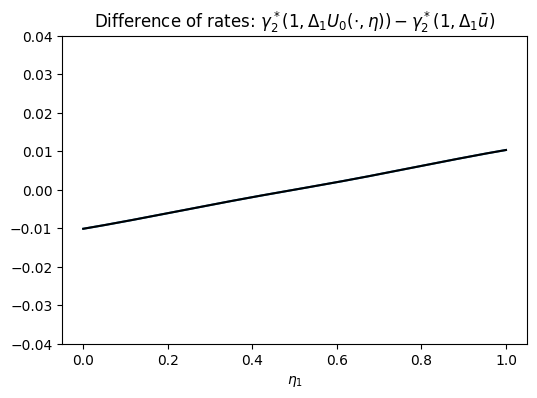

In [ ]:
viz = VizErg(loaded_model)
viz.display_control_difference(orientation = 1)

In [ ]:
# could also do a heatmap with axes mu(1), mu(2), and differences for transitions 12, 13, 23, 21, 31, 32

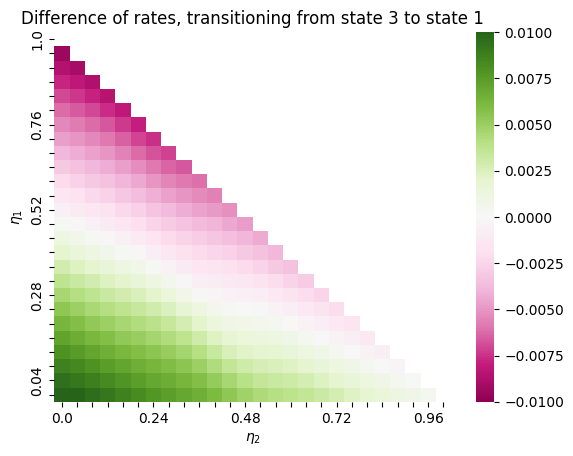

In [ ]:
viz = VizErg(loaded_model)
_, o= viz.display_heatmap(orientation = [2,0])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
import pandas as pd
import plotly.express as px
# init_notebook_mode()

def gamma_difference(num):
  return (num / ((3. - 1.) * 4.) )

num_points = 200
xs = []
ys = []
zs = []


for xv in np.linspace(0,1,num_points):
  for yv in np.linspace(0,1,num_points):
    for zv in np.linspace(0,1,num_points):
      if xv+yv+zv == 1:
        xs.append(xv)
        ys.append(yv)
        zs.append(zv)

xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

data_points = len(xs)

eta_data = np.zeros((data_points, 3))
eta_data[:,0] = xs
eta_data[:,1] = ys
eta_data[:,2] = zs

eta_data = tf.convert_to_tensor(eta_data, dtype='float32')

x0_data = tf.fill((data_points,), 0.)
y0_output = loaded_model(x0_data, eta_data)
x1_data = tf.fill((data_points,), 1.)
y1_output = loaded_model(x1_data, eta_data)
x2_data = tf.fill((data_points,), 2.)
y2_output = loaded_model(x2_data, eta_data)

outputs = [y0_output, y1_output, y2_output]

orientation = [1,2]

np_out = gamma_difference(outputs[orientation[0]].numpy()[:,0] - outputs[orientation[1]].numpy()[:,0])

df = pd.DataFrame({
    'x':xs,
    'y':ys,
    'z':zs,
    'color':np_out
})


fig = go.Figure(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['color'],                # set color to an array/list of desired values
        colorscale='PiYG',   # choose a colorscale
        opacity=0.8,
        colorbar=dict(  # Configure color bar here
            title='Color Bar Title',  # Color bar title
            xpad=10,  # Padding from the right side of the color bar to the plot
            ypad=10,   # Padding from the top side of the color bar to the plot
            orientation = 'h'
        )
    )
)])


fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    title=dict(  # Figure title
        text=f'Transition from state {orientation[0]+1} to state {orientation[1]+1}',
        y=.92,
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    scene=dict(
        xaxis_title=r'η₁',  # LaTeX-style formatting for eta_1
        yaxis_title='η₂',  # Set titles for other axes as needed
        zaxis_title='η₃'
    )
)

# tight layout


# fig.update_layout(  margin=dict(l=0, r=0, b=0, t=0), title="Plot Title", xaxis_title = dict(text='Date'))
# fig.update_layout()
fig.show()